# **Titanic Chatbot**
### By Joel Utoware
This is a chatbot made using information from the Titanic Wikipedia page.

In [56]:
#necesary imports
import re
import requests
import time
import random
from collections import Counter
import string
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image#display image
from wordcloud import WordCloud
from gensim.corpora import Dictionary#dictionary of english words
import nltk #natural language tokenization
from nltk.corpus import stopwords #list ofstopwords
from nltk.tokenize import sent_tokenize,word_tokenize#tokenization

from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

pd.set_option('display.max_colwidth', 0)

In [57]:
#stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Getting the data

In [58]:
site = 'https://en.wikipedia.org/wiki/Titanic'#Website
resp= requests.get(site)
resp.status_code#Checking connection status

200

In [59]:
soup=BeautifulSoup(resp.text,'html.parser')
print(soup.prettify())#View the text data

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-0 vector-feature-appearance-disabled vector-feature-appearance-pinned-clientpref-0 vector-feature-night-mode-disabled skin-theme-clientpref-day vector-toc-available" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Titanic - Wikipedia
  </title>
  <script>
   (function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vec

In [60]:
data=[sentence.get_text() for sentence in soup.find_all('p')]#retrieving the main body of text

In [61]:
data

['\n',
 "RMS Titanic was a British ocean liner that sank on 15 April 1912 after striking an iceberg on the ship's maiden voyage from Southampton, England to New York City, United States. Of the estimated 2,224 passengers and crew aboard, approximately 1,500 died, making the incident the deadliest sinking of a single ship at the time.[a] Titanic, operated by the White Star Line, carried some of the wealthiest people in the world, as well as hundreds of emigrants from the British Isles, Scandinavia, and elsewhere in Europe who were seeking a new life in the United States and Canada. The disaster drew public attention, spurred major changes in maritime safety regulations, and inspired a lasting legacy in popular culture.\n",
 'RMS Titanic was the largest ship afloat upon entering service and the second of three Olympic-class ocean liners built for the White Star Line. The ship was built by the Harland and Wolff shipbuilding company in Belfast. Thomas Andrews Jr., the chief naval architect

# Preparing the data


In [62]:
prep=(' '.join(data)).lower()#removing the text from a list
prep

'\n rms titanic was a british ocean liner that sank on 15 april 1912 after striking an iceberg on the ship\'s maiden voyage from southampton, england to new york city, united states. of the estimated 2,224 passengers and crew aboard, approximately 1,500 died, making the incident the deadliest sinking of a single ship at the time.[a] titanic, operated by the white star line, carried some of the wealthiest people in the world, as well as hundreds of emigrants from the british isles, scandinavia, and elsewhere in europe who were seeking a new life in the united states and canada. the disaster drew public attention, spurred major changes in maritime safety regulations, and inspired a lasting legacy in popular culture.\n rms titanic was the largest ship afloat upon entering service and the second of three olympic-class ocean liners built for the white star line. the ship was built by the harland and wolff shipbuilding company in belfast. thomas andrews jr., the chief naval architect of the 

In [63]:
'''The following two functions are from Digital Futures'''
def regex_clean(txt, regex):
    """Replace any text matching the regex

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove matches
    regex : string
        A text string of the regex pattern you want to match

    Returns
    -------
    The same txt string with the matches removes
    """

    return " ".join(re.sub(regex, "", txt).split())

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)



In [64]:
#clean up data
regex_to_clean = [r'(@.+?)\s',
                  r'\s\d+\s',
                  r'(//t.co/.+?)\s',
                  r'(//t.co/.+?)',
                  r'\[.*?\]']
#remove all matched patterns
for reg in regex_to_clean:
    prep = regex_clean(prep,reg)

#get rid of emojis
prep =remove_emoji(prep)
prep

'rms titanic was a british ocean liner that sank onaprilafter striking an iceberg on the ship\'s maiden voyage from southampton, england to new york city, united states. of the estimated 2,224 passengers and crew aboard, approximately 1,500 died, making the incident the deadliest sinking of a single ship at the time. titanic, operated by the white star line, carried some of the wealthiest people in the world, as well as hundreds of emigrants from the british isles, scandinavia, and elsewhere in europe who were seeking a new life in the united states and canada. the disaster drew public attention, spurred major changes in maritime safety regulations, and inspired a lasting legacy in popular culture. rms titanic was the largest ship afloat upon entering service and the second of three olympic-class ocean liners built for the white star line. the ship was built by the harland and wolff shipbuilding company in belfast. thomas andrews jr., the chief naval architect of the shipyard, died in 

In [65]:
#tokenisation
wd=word_tokenize(prep)
print(wd)

['rms', 'titanic', 'was', 'a', 'british', 'ocean', 'liner', 'that', 'sank', 'onaprilafter', 'striking', 'an', 'iceberg', 'on', 'the', 'ship', "'s", 'maiden', 'voyage', 'from', 'southampton', ',', 'england', 'to', 'new', 'york', 'city', ',', 'united', 'states', '.', 'of', 'the', 'estimated', '2,224', 'passengers', 'and', 'crew', 'aboard', ',', 'approximately', '1,500', 'died', ',', 'making', 'the', 'incident', 'the', 'deadliest', 'sinking', 'of', 'a', 'single', 'ship', 'at', 'the', 'time', '.', 'titanic', ',', 'operated', 'by', 'the', 'white', 'star', 'line', ',', 'carried', 'some', 'of', 'the', 'wealthiest', 'people', 'in', 'the', 'world', ',', 'as', 'well', 'as', 'hundreds', 'of', 'emigrants', 'from', 'the', 'british', 'isles', ',', 'scandinavia', ',', 'and', 'elsewhere', 'in', 'europe', 'who', 'were', 'seeking', 'a', 'new', 'life', 'in', 'the', 'united', 'states', 'and', 'canada', '.', 'the', 'disaster', 'drew', 'public', 'attention', ',', 'spurred', 'major', 'changes', 'in', 'mariti

# EDA


This will give an idea of what words appear frequently in the data

In [66]:
def clean(data):
  '''takes the list of tokenized words and removes puctuation and stopwords. '''
  stpwrd = nltk.corpus.stopwords.words('english')
  data=[words for words in data if words not in stpwrd]
  data = [words.translate(str.maketrans('', '', string.punctuation)) for words in data]#remove punctuation
  data=[words for words in data if words!='']# removing empty data
  return data

In [67]:
before=len(wd)#how many words before cleaning
wd=clean(wd)
after=len(wd)#how many words before cleaning


In [68]:
print(f'{before}\n{after}')

16655
8791


In [69]:
filter=[token for token in wd if len(token)>2]#only keep words that are more than 2 letters
len(filter)

8433

## Word Cloud

The top 100 words in the wikipedia page. This shows that the data is suitable for a question and answer chatbot due the data being focused on words involving the Titanic.

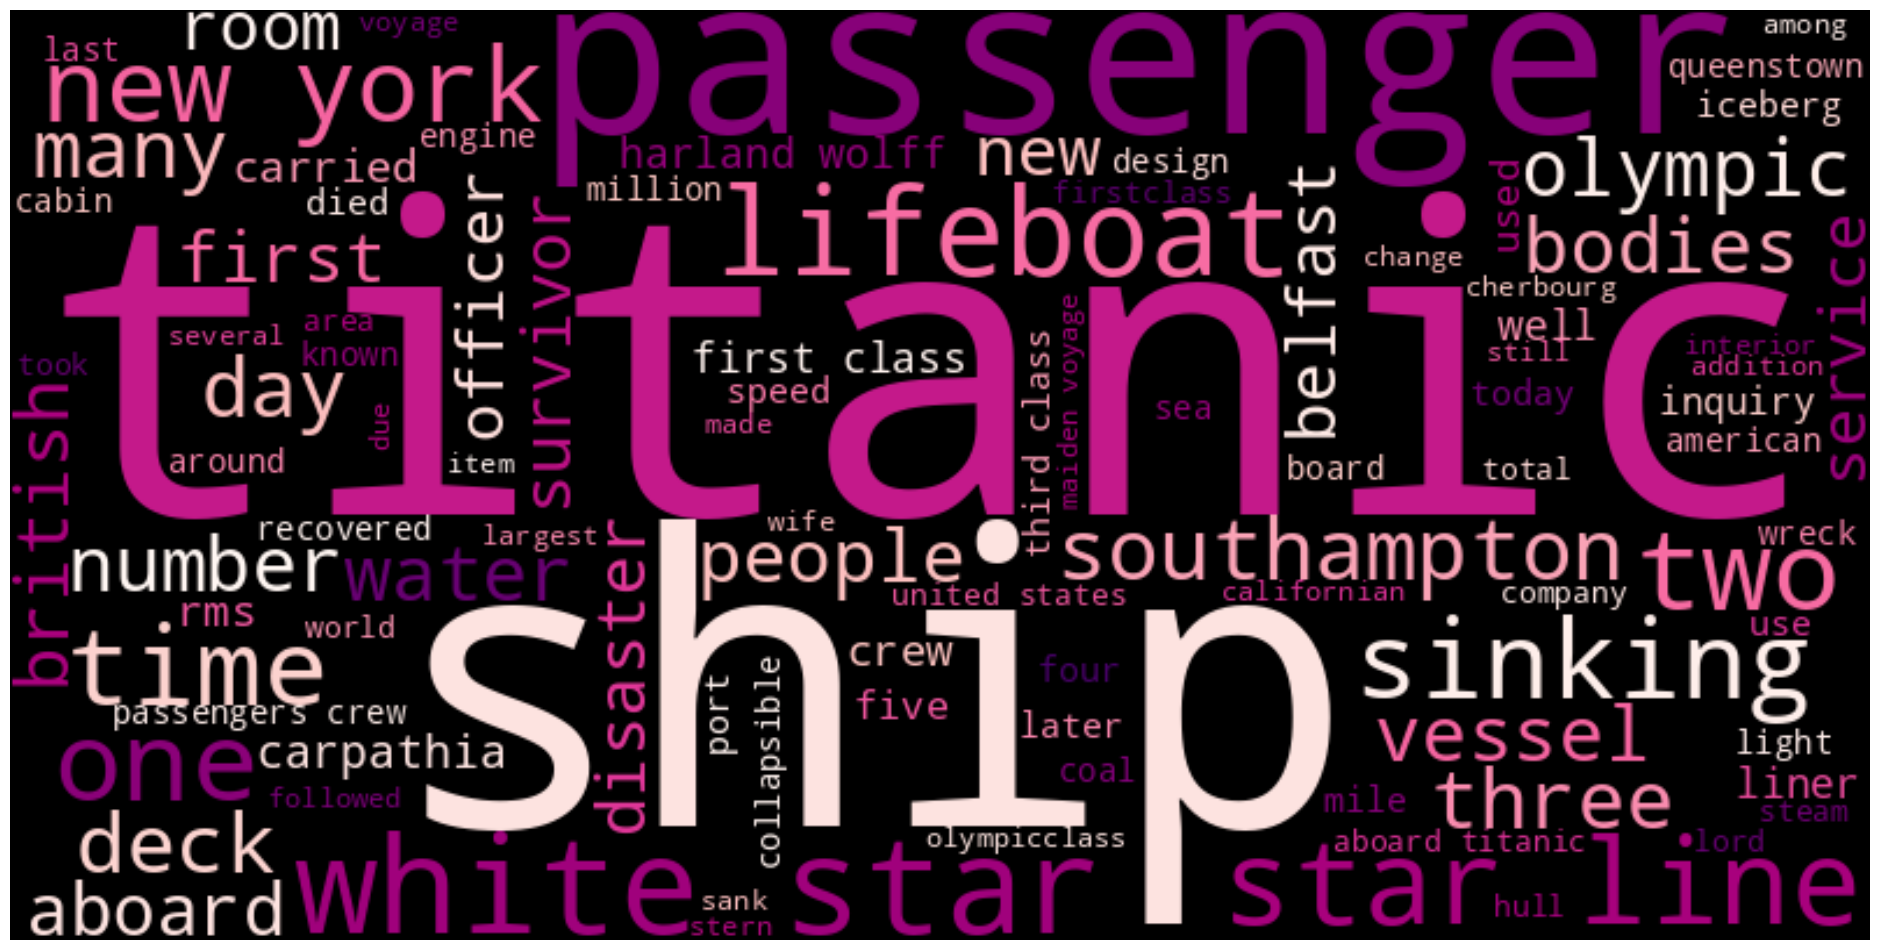

In [70]:
joined_words=' '.join(filter)
wc = WordCloud(width=800, height=400, max_words=100,background_color='black',colormap='RdPu').generate(joined_words)
plt.figure(figsize=(24,20))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Top ten most common words

In [71]:
count = Counter(filter)
top10=count.most_common(10)

In [72]:
word,num=zip(*top10)

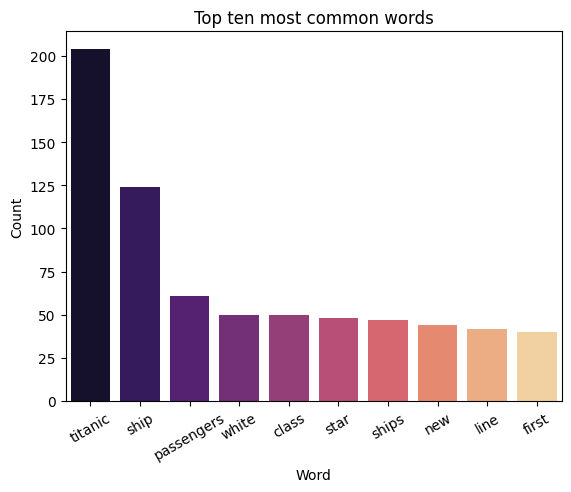

In [73]:
sns.barplot(x=word,y=num,hue=word,palette='magma')
plt.xticks(rotation=30)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top ten most common words')
plt.show()

# Transfer Learning comparison


Used transfer learning for this chatbot, this is using pre-trained models for a task (in this case a chatbot) and fine tuning it for your own work.
The following is a comparison on select models.

In [74]:
quest=[['What company built the Titanic?','Harland and Wolff shipbuilding company'],['What year was the maiden voyage of the Titanic?',1912],
       ['Why did the Titanic sink?','iceberg'],['What year was the sunken Titanic found?',1985],['How many people were on the Titanic before it sunk?','~2224'],
       ['What is the Radio Act of 1912?','Radio communications on passenger ships would be operated 24 hours a day']]#Questions to model the chatbot performance

testQ=pd.DataFrame(data=quest,columns=['Question','Answer'])

In [75]:
testQ.head(10)

,Question,Answer
0,What company built the Titanic?,Harland and Wolff shipbuilding company
1,What year was the maiden voyage of the Titanic?,1912
2,Why did the Titanic sink?,iceberg
3,What year was the sunken Titanic found?,1985
4,How many people were on the Titanic before it sunk?,~2224
5,What is the Radio Act of 1912?,Radio communications on passenger ships would be operated 24 hours a day


In [76]:
def test(df):
  '''This function takes a dataframe and adds:
   -The answers generated by the tested models
   -The f1 score for the question
   -The time taken to generate an answer'''
  QA_input = {
    'question': df['Question'],
    'context':  prep
    }
  start = time.time()
  res=rbs(QA_input)
  end = time.time()
  df['rbs_answer']=res['answer']
  df['rbs_F1score']=res['score']
  df['rbs_time']=end - start

  start = time.time()
  res=intel(QA_input)
  end = time.time()
  df['intel_answer']=res['answer']
  df['intel_F1score']=res['score']
  df['intel_time']=end - start

  start = time.time()
  res=mdeberta(QA_input)
  end = time.time()
  df['mdeberta_answer']=res['answer']
  df['mdeberta_F1score']=res['score']
  df['mdeberta_time']=end - start

  start = time.time()
  res=distilbert(QA_input)
  end = time.time()
  df['distil_answer']=res['answer']
  df['distil_F1score']=res['score']
  df['distil_time']=end - start

  return df

In [77]:
'''All modells were from hugging face.com
https://huggingface.co/deepset/roberta-base-squad2
https://huggingface.co/Intel/dynamic_tinybert
https://huggingface.co/timpal0l/mdeberta-v3-base-squad2
https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad'''

rbs= pipeline('question-answering', model='deepset/roberta-base-squad2', tokenizer='deepset/roberta-base-squad2')

intel= pipeline('question-answering', model='Intel/dynamic_tinybert', tokenizer='Intel/dynamic_tinybert')

mdeberta= pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

distilbert= pipeline("question-answering", model='distilbert-base-cased-distilled-squad')


In [78]:
testQ=testQ.apply(test,axis=1)

In [79]:
testQ.head(10)

,Question,Answer,rbs_answer,rbs_F1score,rbs_time,intel_answer,intel_F1score,intel_time,mdeberta_answer,mdeberta_F1score,mdeberta_time,distil_answer,distil_F1score,distil_time
0,What company built the Titanic?,Harland and Wolff shipbuilding company,harland and wolff,0.829957,136.172940,harland and wolff shipbuilding company,0.870736,61.792789,"harland & wolff,",0.821906,224.668613,rms olympic,0.818762,62.144780
1,What year was the maiden voyage of the Titanic?,1912,1912,0.911630,131.609956,1912,0.989944,62.592086,1912.,0.980619,222.889449,1912,0.980302,67.495550
2,Why did the Titanic sink?,iceberg,striking an iceberg,0.713669,130.513332,the ship had been considered unsinkable,0.668595,60.986993,heavy rain.,0.868591,217.037397,the ship could not remain afloat with more than four compartments flooded,0.602389,61.776518
3,What year was the sunken Titanic found?,1985,1912,0.407147,130.517767,1911,0.760916,66.168178,1912.,0.989594,218.173344,1912,0.983745,64.135196
4,How many people were on the Titanic before it sunk?,~2224,"2,224",0.205572,130.438727,"1,517",0.838244,62.469513,"2,224",0.919506,221.915943,49.94694,0.846054,64.668941
5,What is the Radio Act of 1912?,Radio communications on passenger ships would be operated 24 hours a day,radio communications on passenger ships would be operatedhours a day,0.087201,130.416867,stated that radio communications on passenger ships would be operatedhours a day,0.123130,61.022687,stated that radio communications on passenger ships,0.071833,217.682287,radio communications on passenger ships would be operatedhours a day,0.244382,63.463952


# Visulize results

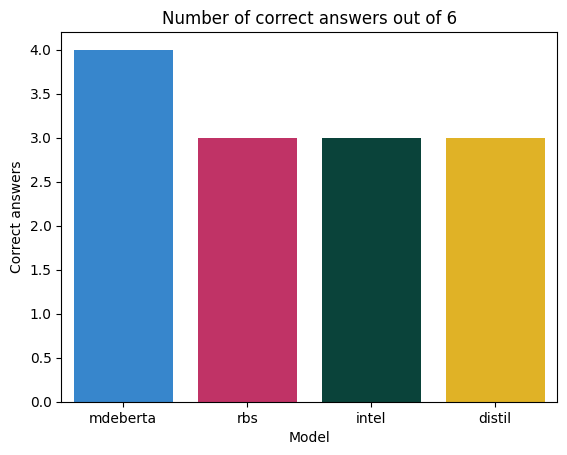

In [80]:
models=['rbs','intel','mdeberta','distil']
sns.barplot(x=models,
            y=[3,3,4,3],
            palette=['#D81B60','#004D40','#1E88E5','#FFC107'],
            hue=models,
            order=['mdeberta','rbs','intel','distil'])
plt.xlabel('Model')
plt.ylabel('Correct answers')
plt.title('Number of correct answers out of 6')
plt.show()

In [81]:
quest_num=['Q1','Q2','Q3','Q4','Q5','Q6']

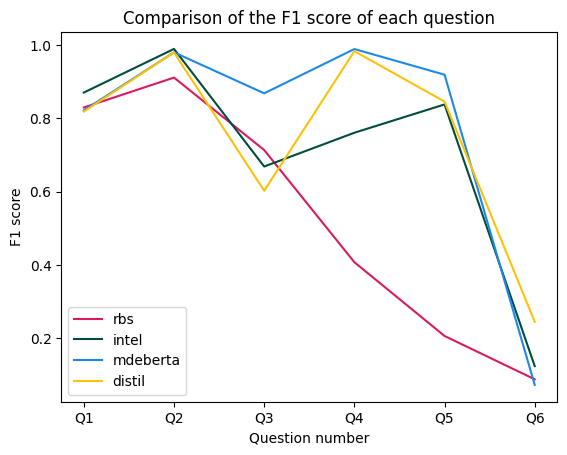

In [82]:
sns.lineplot(x=quest_num,y=testQ['rbs_F1score'],color='#D81B60',label='rbs')
sns.lineplot(x=quest_num,y=testQ['intel_F1score'],color='#004D40',label='intel')
sns.lineplot(x=quest_num,y=testQ['mdeberta_F1score'],color='#1E88E5',label='mdeberta')
sns.lineplot(x=quest_num,y=testQ['distil_F1score'],color='#FFC107',label='distil')
plt.xlabel('Question number')
plt.ylabel('F1 score')
plt.title('Comparison of the F1 score of each question')
plt.legend()
plt.show()

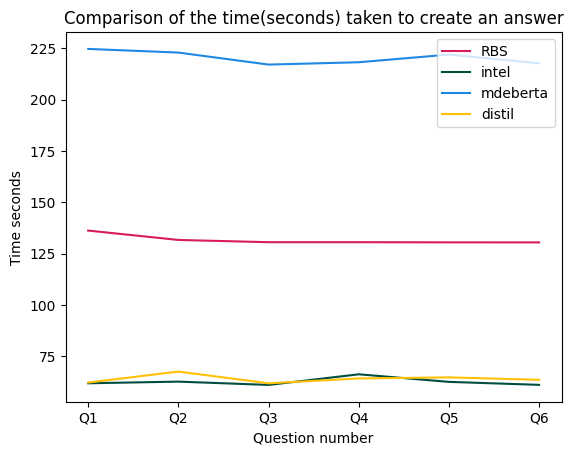

In [83]:
sns.lineplot(x=quest_num,y=testQ['rbs_time'],color='#D81B60',label='RBS')
sns.lineplot(x=quest_num,y=testQ['intel_time'],color='#004D40',label='intel')
sns.lineplot(x=quest_num,y=testQ['mdeberta_time'],color='#1E88E5',label='mdeberta')
sns.lineplot(x=quest_num,y=testQ['distil_time'],color='#FFC107',label='distil')
plt.xlabel('Question number')
plt.ylabel('Time seconds')
plt.title('Comparison of the time(seconds) taken to create an answer')
plt.legend()
plt.show()

# Creating the Chatbot

It was decided to use the Intel/dynamic_tinybert (Intel) model as it was the fastest model and a quick response is more suitale for a chatbot.

In [84]:
greet=['hi','hello','helloo','hellooo','hey','heeyy','greetings','good to see you',"it's good seeing you"]
bye=['goodbye','farewell','see ya next time','see ya','bye']

In [85]:
def chat():
  '''Allows the user to:
  - say a greeting and be given a greeting back
  -ask questions and get a response back
  - say farewell to end the function'''
  talking=True
  print("Hello, welcome to the Titanic Chatbot. I'll do my best to answer questions about the Titanic.\nType bye or a similar phrase to end the chat.")
  while talking==True:
    q=input('\nWhat would you like to know: ')
    if q.lower() in bye:
      talking=False
      print(f'Thank you for using the Titanic chatbot, {random.choice(bye)}.')
      break # ends the chatbot
    elif q.lower() in greet:
      print(random.choice(greet).capitalize())
    else:
      QA_input = {
          'question': q,
          'context':  prep
          }
      res=intel(QA_input)
      #depending on the f1 score of the response a differed sentence starter is used.
      if res['score']>0.7:
        print (f'I am very certain the answer is: {res["answer"]}')
      elif res['score']>0.4:
        print(f'The answer might be: {res["answer"]}')
      else:# if the f1 score is too low then no answer is given
        print(f'Sorry I do not know the answer, perhaps add more context to your question.')

In [91]:
chat()

Hello, welcome to the Titanic Chatbot. I'll do my best to answer questions about the Titanic.
Type bye or a similar phrase to end the chat.

What would you like to know: where was the titanic built
I am very certain the answer is: belfast, ireland

What would you like to know: bye
Thank you for using the Titanic chatbot, farewell.
